In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
from step7.Ecommerce7 import*

### Scenario Recap

In [ ]:
ecomm3_gpts, ecomm3_gpucb, env = observe_learned_functions()
plot_learned_functions(ecomm3_gpts, ecomm3_gpucb, env)

## Step 3

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


Experiment n°: 2


n_iteration: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


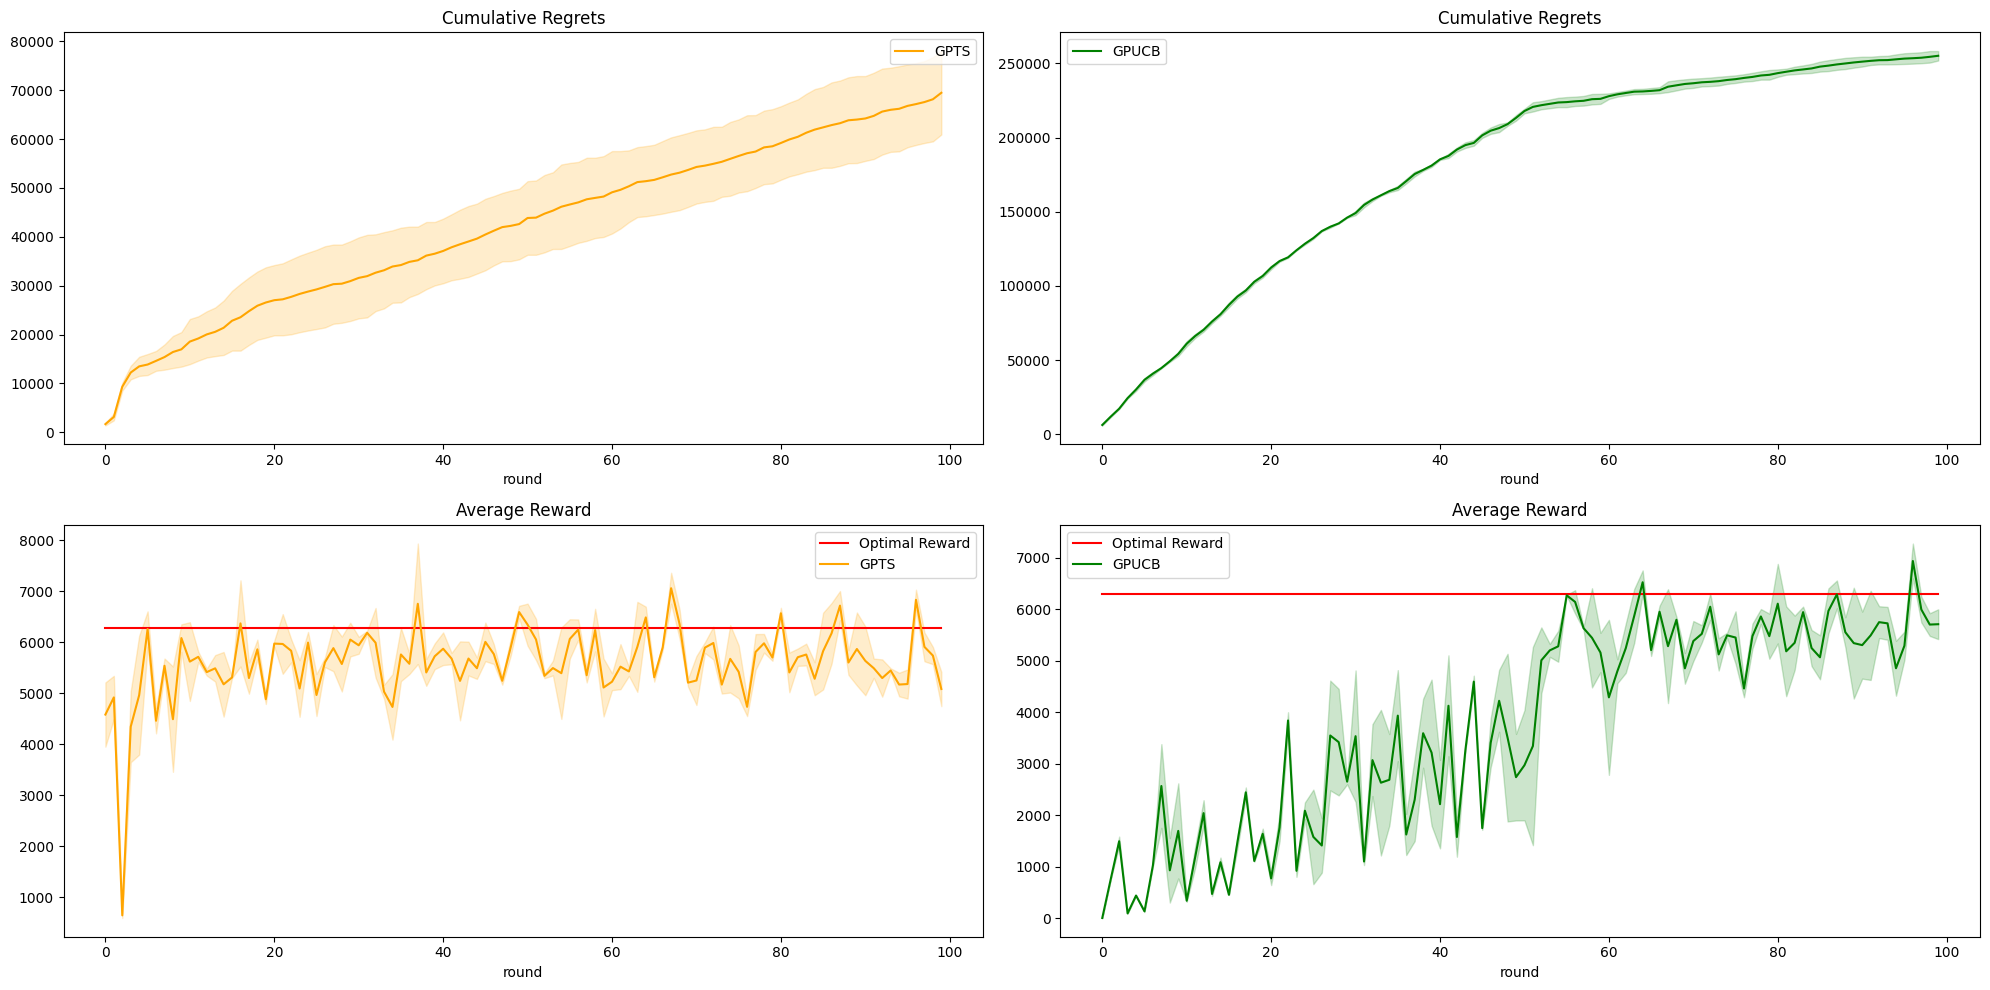

In [2]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

In [4]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

Experiment n°: 1


n_iteration: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


Experiment n°: 2


n_iteration:  64%|██████▍   | 64/100 [00:57<00:48,  1.35s/it]

## Step 5

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"])

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

In [2]:
! python gp_parameter_optimizer.py

rmse = 5.051992509185846, hyperparams: (alpha = 4.07378521777283, c_const = 4.448995063979709, rbf_ls = 81.76445510121661)

rmse = 4.872101413376987, hyperparams: (alpha = 3.552889547630187, c_const = 92.55353500419224, rbf_ls = 61.985896527984664)

rmse = 4.285796791229592, hyperparams: (alpha = 2.359493599883817, c_const = 69.4361104068423, rbf_ls = 7.0475946025746055)

rmse = 5.426647796665498, hyperparams: (alpha = 4.966098767437074, c_const = 13.781587615590055, rbf_ls = 52.68991246926643)

rmse = 4.314732879248154, hyperparams: (alpha = 2.2703423359683303, c_const = 79.51655092524825, rbf_ls = 21.176011367143357)

rmse = 4.876904462662957, hyperparams: (alpha = 3.9483105406880523, c_const = 60.21320608147951, rbf_ls = 29.369196961718625)

rmse = 4.473540581111029, hyperparams: (alpha = 2.6307540298203564, c_const = 44.66692310635111, rbf_ls = 54.908644056185416)

rmse = 4.801840048400412, hyperparams: (alpha = 2.948020229964705, c_const = 17.428717815882457, rbf_ls = 71.203595783